# MIMICScn_HIST
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
  - Reduced HR biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/*/OUTPUT_CN/SPIN

### Notable parameter changes
- Increased MIMICS leaching (function of total DIN pool) 
- Removed density dependent turnover, beta function from Emily's paper
- Introduces flexible microbial C:N, as a function of `fmet` to increase MIC C:N
- Increases FI from inputs to SOMc to increase C:N of total pools
- Decreases KO from 6 to 4, reduces SOMc stocks
- MIMICS and CASA simulation in CN mode and C only.
- **`MIMICS_mod5_GSWP3_KO4`** + `MIMICS_mod5_Conly_KO4`
- `CASACNP_mod4_GSWP3` + `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
from matplotlib import cm

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 0.16.1


In [2]:
path= '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
sim = ['MIMICS_mod5_GSWP3_KO4',
       'MIMICS_mod5_Conly_KO4',
       'CASACNP_mod4_GSWP3', 
       'CASACNP_mod4_Conly']
year  = [1901,2014] # for first and last year of simulations 
fin = [path + i for i in sim]

CNtype = ['CN','C','CN','C']
suffix = ['/OUTPUT_'+j+'/HIST/' for j in CNtype]

fin = [i + j for i, j in zip(fin, suffix)]
models = ['mimics','casaclm']
file = ['ann_'+i+'_pool_flux_'+str(year[0])+'_'+str(year[1])+'.nc' for i in models]
nsim =len(sim)
file

['ann_mimics_pool_flux_1901_2014.nc', 'ann_casaclm_pool_flux_1901_2014.nc']

In [3]:
# files for daily data
fileDay1901 = [i+'_pool_flux_'+str(year[0])+'_daily.nc' for i in models]
fileDay2014 = [i+'_pool_flux_'+str(year[1])+'_daily.nc' for i in models]
fileDay1901

['mimics_pool_flux_1901_daily.nc', 'casaclm_pool_flux_1901_daily.nc']

### Open datasets and combine MIMICS output into one file
 - This is pretty slow, can we use DASK on CGD machines?

In [4]:
# point to files
files_mim = [i + file[0] for i in fin[0:2]]
files_mimDay1901 = [i + fileDay1901[0] for i in fin[0:2] ]
files_mimDay2014 = [i + fileDay2014[0] for i in fin[0:2] ]

sim_mim = ['MIMcn', 'MIMc']
simdim_mim  = xr.DataArray(sim_mim, dims='sim', name='sim')
dims_mim    = [simdim_mim]

# Open annual time series
tmp_mim = xr.open_mfdataset(files_mim,combine='nested',concat_dim=dims_mim)

# Open Daily data in 1901
tmp_mimDay1901 = xr.open_mfdataset(files_mimDay1901,combine='nested',
                               concat_dim=dims_mim)
# Open daily data in 2014
tmp_mimDay2014 = xr.open_mfdataset(files_mimDay2014,combine='nested',
                               concat_dim=dims_mim)
print('--- read in MIMICS data ---')

--- read in MIMICS data ---


In [5]:
# point to files
files_cas = [i + file[1] for i in fin]
files_casDay1901 = [i + fileDay1901[1] for i in fin ]
files_casDay2014 = [i + fileDay2014[1] for i in fin ]

sim_cas = ['MIMcn', 'MIMc','CAScn','CASc']
simdim_cas  = xr.DataArray(sim_cas, dims='sim', name='sim')
dims_cas    = [simdim_cas]

# Open annual time series
tmp_cas = xr.open_mfdataset(files_cas,combine='nested',concat_dim=dims_cas)
# Open Daily data in 1901
tmp_casDay1901 = xr.open_mfdataset(files_casDay1901,combine='nested',
                               concat_dim=dims_cas)
# Open daily data in 2014
tmp_casDay2014 = xr.open_mfdataset(files_casDay2014,combine='nested',
                               concat_dim=dims_cas)

print('--- read in CASA data ---')

--- read in CASA data ---


### Merge daily data into a single file

In [6]:
dsmimDay = xr.combine_by_coords([tmp_mimDay1901,tmp_mimDay2014],
                                combine_attrs='drop')
dscasDay = xr.combine_by_coords([tmp_casDay1901,tmp_casDay2014],
                                combine_attrs='drop')
dscasDay

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, sim: 4, time: 730)
Coordinates:
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * time                 (time) float64 1.901e+03 1.901e+03 ... 2.015e+03
  * sim                  (sim) <U5 'MIMcn' 'MIMc' 'CAScn' 'CASc'
Data variables:
    day                  (sim, time) int32 1 2 3 4 5 6 ... 361 362 363 364 365
    IGBP_PFT             (time, sim, lat, lon) float64 nan nan nan ... nan nan
    landarea             (time, sim, lat, lon) float32 nan nan nan ... nan nan
    cellMissing          (time, sim, lat, lon) int32 1 1 1 1 1 1 ... 1 1 1 1 1 1
    cellid               (time, sim, lat, lon) int32 1 97 193 ... 13728 13824
    cresp                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cnpp                 (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cgpp                 (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cleaf                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nleaf                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cwood                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nwood                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cfroot               (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nfroot               (sim, time, lat, lon) float32 nan nan nan ... nan nan
    clitmetb             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nlitmetb             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    clitstr              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nlitstr              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    clitcwd              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nlitcwd              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    csoilmic             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nsoilmic             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    csoilslow            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nsoilslow            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    csoilpass            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nsoilpass            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    tairC                (sim, time, lat, lon) float32 nan nan nan ... nan nan
    tsoilC               (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cLitInptMet          (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cLitInptStruc        (sim, time, lat, lon) float32 nan nan nan ... nan nan
    cpassInpt            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    thetaLiq             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    fT                   (sim, time, lat, lon) float32 nan nan nan ... nan nan
    fW                   (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nLitInptMet          (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nLitInptStruc        (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMinDep              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMinFix              (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMinUptake           (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMinLeach            (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMinLoss             (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nLitMineralization   (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nSoilMineralization  (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nSoilImmob           (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nNetMineralization   (sim, time, lat, lon) float32 nan nan nan ... nan nan
    nMineral             (sim, time, lat, lon

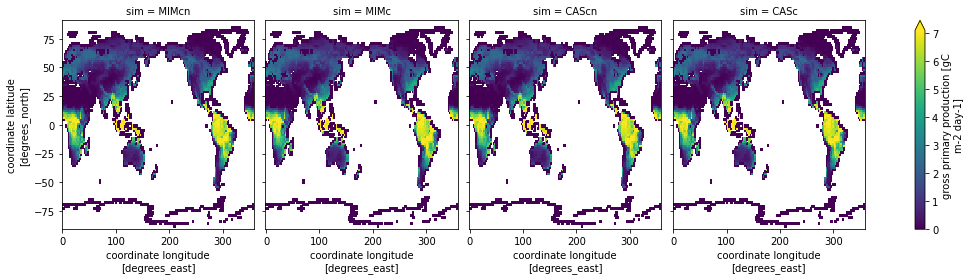

In [7]:
# still need to be careful for non-zero variables
tmp_cas.cgpp.isel(time=0).plot(x="lon", y="lat", col="sim", 
                               robust=True,figsize=[15,4],
                               col_wrap=nsim)  ;

### Combine datasets by simullaltion

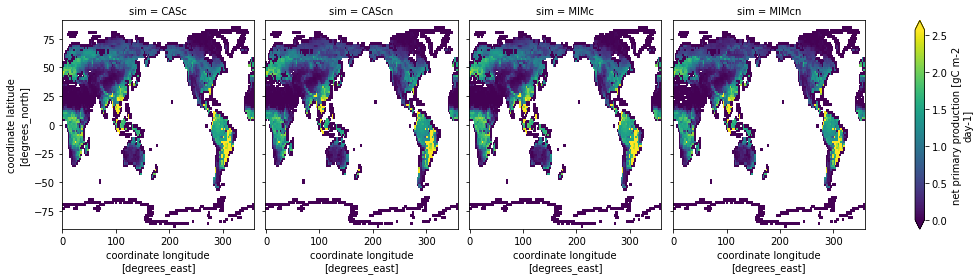

In [8]:
ds = xr.combine_by_coords([tmp_mim,tmp_cas],compat='override',
                          combine_attrs='drop')
dsDay = xr.combine_by_coords([dsmimDay,dscasDay],compat='override',
                             combine_attrs='drop')

ds.cnpp.isel(time=0).plot(x="lon", y="lat", col="sim", 
                          robust=True,figsize=[15,4],
                          col_wrap=nsim)  ;

In [9]:
DOY = 2*list(range(1,366))
dsDay['time'] = DOY 
#dsDay.rename({'time': 'DOY')

### Sum soil C & N pools
- uses utilities to create new diagnostics

In [10]:
# unsure how to subset simulations to run utilities a different way...
# -- Xarray notes: We would love to be able to do indexing with labeled dimension names inside brackets, 
#    but unfortunately, Python does yet not support indexing with keyword arguments --
ds = ds.transpose('sim','lat','lon','time')
test0 = utils.sum_pools_combined(ds.isel(sim=0),'cas',CN='False')
test1 = utils.sum_pools_combined(ds.isel(sim=1),'cas',CN='True')
test2 = utils.sum_pools_combined(ds.isel(sim=2),'mim',CN='False')
test3 = utils.sum_pools_combined(ds.isel(sim=3),'mim',CN='True')
ds= xr.concat([test0,test1,test2,test3],'sim')

dsDay = dsDay.transpose('sim','lat','lon','time')
test0 = utils.sum_pools_combined(dsDay.isel(sim=0),'cas',CN='False')
test1 = utils.sum_pools_combined(dsDay.isel(sim=1),'cas',CN='True')
test2 = utils.sum_pools_combined(dsDay.isel(sim=2),'mim',CN='False')
test3 = utils.sum_pools_combined(dsDay.isel(sim=3),'mim',CN='True')
dsDay= xr.concat([test0,test1,test2,test3],'sim')

# lists to identify simulations later
CNsim = [1,3]  
MIMsim = [2,3]

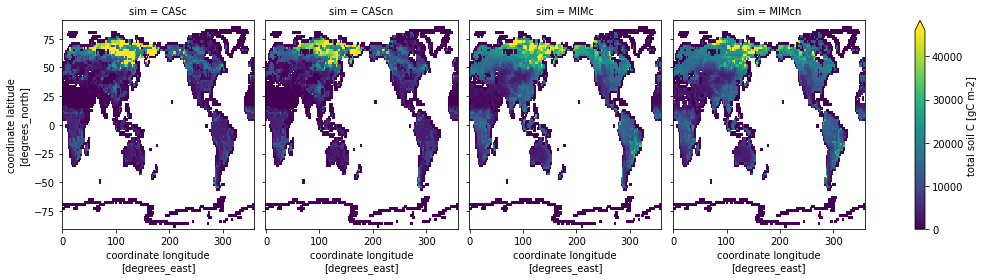

In [11]:
ds.cTOT.isel(time=0).plot(x="lon", y="lat", col="sim", 
                          robust=True,figsize=[15,4],
                          col_wrap=nsim)  ;

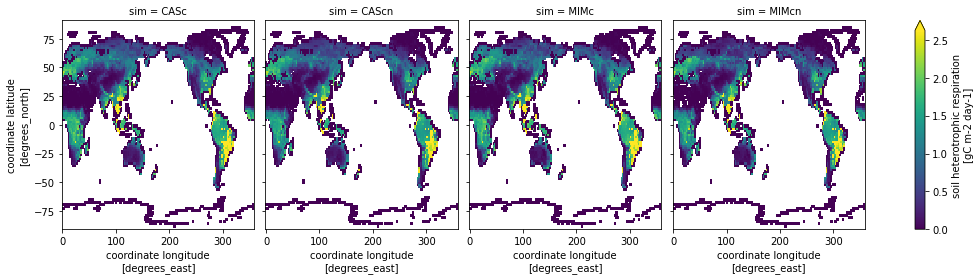

In [12]:
# check for correct fluxes (from utilities)
ds.cresp.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

#### Mask out low productivity grids (where NPP<10 gC/m2/y)
- Use mean of first 20 years from MIMICScn run to ensure same mask for all simulations

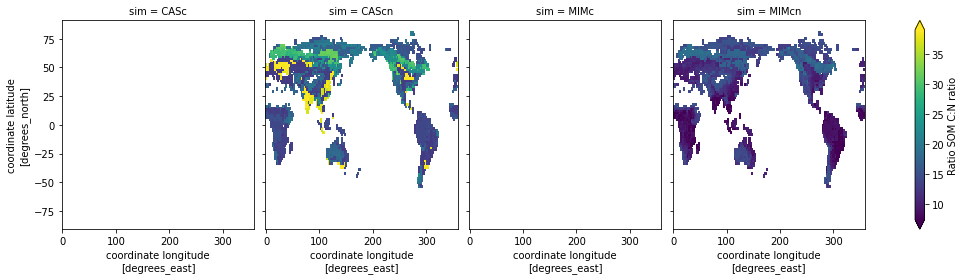

In [13]:
minNPP = 10/365 # npp given in gC/m2/d
initNPP = ds.cnpp.isel(sim=3,time=slice(0,20)).mean(dim='time')
#print(initNPP)                            
ds = ds.where(initNPP>minNPP)
dsDay = dsDay.where(initNPP>minNPP)
ds.cnTOT.isel(time=0).plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

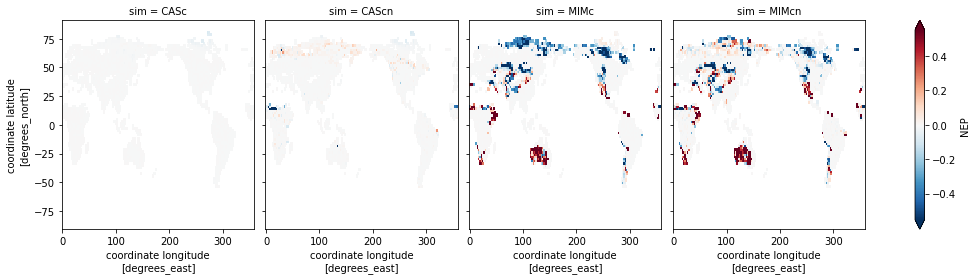

In [14]:
# QUICK LOOK AT MEAN NEP, 1901-1920, converted to gC/m2/y
(ds.NEP.isel(time=slice(0,20)).mean(dim='time')*365).plot(
    x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim)  ;

mean MICc:SOMc 0.8930174


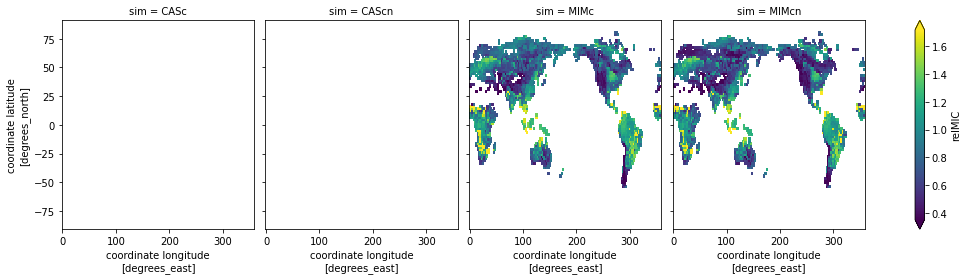

In [15]:
(ds.relMIC.isel(time=slice(0,20)).mean(dim='time')).plot(
     x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);
print('mean MICc:SOMc '+str(
    (ds.relMIC.isel(time=0)*ds.landarea/ds.landarea.sum()).sum().values))

### Calculate zonal means

In [16]:
zon_mean = ds.mean(dim='lon') 

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

# Read observations:
- Microbial C and C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [17]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
#dsXu.CN100cm.plot(robust=True);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
print('max soil C:N '+str(GSDEoc['CNmean'].max().values))
#mask out silly values
GSDEoc['CNmean2'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
zon_stdOBS = dsOBS.std(dim='lon') * 1000 #gC/m2
print('')
print('-- read in observed data -- ')
#dsNCSCD.NCSCD_SOC

max soil C:N 5353.0

-- read in observed data -- 


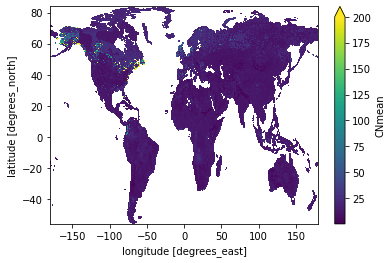

In [18]:
GSDEoc['CNmean'].plot(vmax=200);
#CNtemp = xr.concat([GSDEoc['CNmean'],GSDEoc['CNmean2']],'soilCN')
#print(CNtemp)
#simple = CNtemp.plot(col="soilCN", col_wrap=2,robust=True);

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/
MIMICS_mod5_GSWP3_KO4


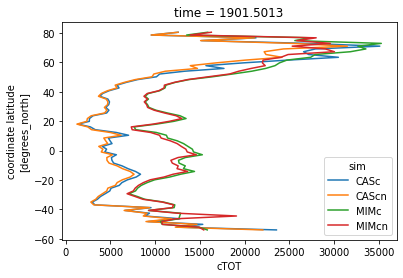

In [19]:
zon_mean.cTOT.isel(time=0).plot(hue='sim',y='lat') ;
print(fin[0])
print(sim[0])

### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwiede

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_1_ZonalSOM.pdf --


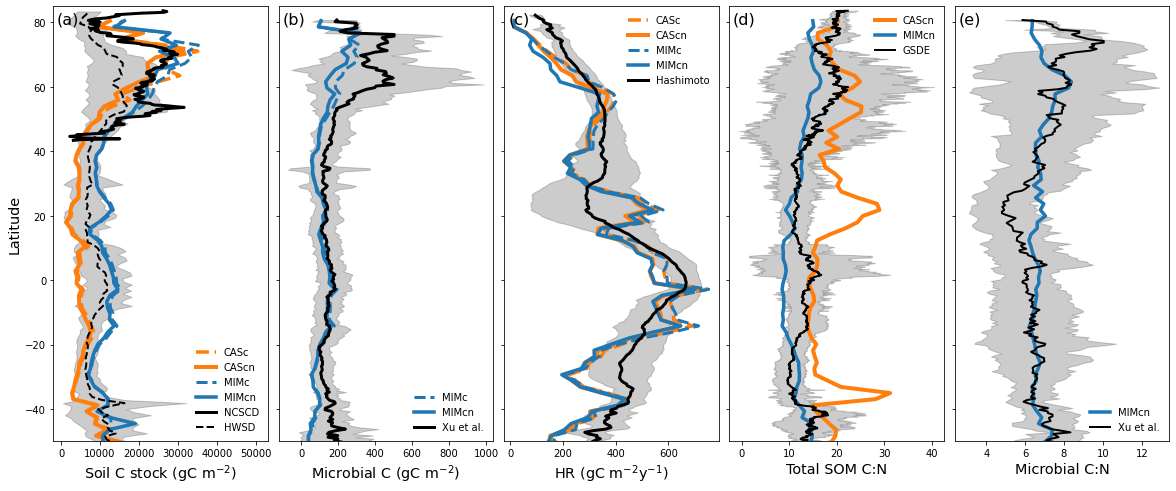

In [20]:
tPlot = 0  #time period to plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)

simLabs = ds['sim'].values.tolist()
color = ['tab:orange','tab:orange','tab:blue','tab:blue','tab:red'] 
lw = [3.5,4,3.,3.5,3.5] 
linestyle= ['--', '-','--', '-', '-']                        

# SOC
v = 'cTOT'
labels = simLabs+['NCSCD','HWSD']
for i in range(nsim):
    ax1.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.fill_betweenx(zon_meanOBS.lat,
                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
                  alpha=0.2, color='k')

ax1.set_xlabel('Soil C stock (gC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_ylim(-50, 85)

# MICc
v = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = simLabs[2:nsim]+['Xu et al.']
for i in range(2,nsim):
    ax2.plot(zon_mean.get(v).isel(time=tPlot,sim=i), 
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax2.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.SMC100cm.mean(dim='lon') + dsXu.SMC100cm.std(dim='lon'), 
                  dsXu.SMC100cm.mean(dim='lon') - dsXu.SMC100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax2.set_xlabel('Microbial C (gC $\mathregular{m^{-2}}$)', fontsize='x-large');
ax2.legend(labels=labels,frameon = False, fontsize='medium',loc=4)

# HR
v = 'cresp' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = simLabs+['Hashimoto']
for i in range(nsim):
    # fluxes gC/m2/d
    ax3.plot(zon_mean.get(v).isel(time=tPlot,sim=i)*365,    
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax3.plot(dsHR.co2.isel(time=-1,lev=0).mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax3.fill_betweenx(dsHR.lat,   #add SD by lat
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') + dsHR.co2.isel(time=-1,lev=0).std(dim='lon'), 
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') - dsHR.co2.isel(time=-1,lev=0).std(dim='lon'),
                  alpha=0.2, color='k')
ax3.set_xlabel('HR (gC $\mathregular{m^{-2 } y^{-1}}$)', fontsize='x-large')
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# Soil C:N
v = 'cnTOT' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = [simLabs[i] for i in [1,3]]+['GSDE']
for i in [1,3]:
    # fluxes gC/m2/d
    ax4.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax4.plot(GSDEoc['CNmean2'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
#ax4.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='r')
ax4.fill_betweenx(GSDEoc.lat,   #add SD by lat
                  GSDEoc['CNmean2'].mean(dim='lon') + GSDEoc['CNmean2'].std(dim='lon'), 
                  GSDEoc['CNmean2'].mean(dim='lon') - GSDEoc['CNmean2'].std(dim='lon'),
                  alpha=0.2, color='k')
ax4.set_xlabel('Total SOM C:N', fontsize='x-large');
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=0)

# MIC C:N
v = 'cnMIC' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
labels = [simLabs[i] for i in [3]]+['Xu et al.']
for i in [3]:
    # fluxes gC/m2/d
    ax5.plot(zon_mean.get(v).isel(time=tPlot,sim=i),   
             zon_mean.lat,lw=lw[i],color=color[i],linestyle=linestyle[i])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.CN100cm.mean(dim='lon') + dsXu.CN100cm.std(dim='lon'), 
                  dsXu.CN100cm.mean(dim='lon') - dsXu.CN100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax5.set_xlabel('Microbial C:N', fontsize='x-large');
ax5.legend(labels=labels, frameon = False, fontsize='medium',loc=0);

# add panel labels
ax1.annotate(panel[0], xy=(0.07, 0.97), xycoords=ax1.transAxes, ha='center', va='center',fontsize=16)    
ax2.annotate(panel[1], xy=(0.07, 0.97), xycoords=ax2.transAxes, ha='center', va='center',fontsize=16)    
ax3.annotate(panel[2], xy=(0.07, 0.97), xycoords=ax3.transAxes, ha='center', va='center',fontsize=16)    
ax4.annotate(panel[3], xy=(0.07, 0.97), xycoords=ax4.transAxes, ha='center', va='center',fontsize=16)    
ax5.annotate(panel[4], xy=(0.07, 0.97), xycoords=ax5.transAxes, ha='center', va='center',fontsize=16);    

fout = fin[0]+'figs/'+sim[0]+'_Fig_1_ZonalSOM.pdf'
plt.savefig(fout)
print(' -- wrote '+fout+' --')

**Figure 1.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevant observations, (black lines with grey shading showing +/- 1 sigma of mean). Panels show (a) initial soil C stocks (gC m-2, 0-100 cm depth), (b) soil microbial biomass C stocks (gC m-2, 0-100 cm depth), (c) soil heterotrophic respiration fluxes (gC m-2 y-1),  (d) soil organic matter C:N ratio, and (e) microbial biomass C:N ratios.  See text for references of observations used in this analysis.

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N

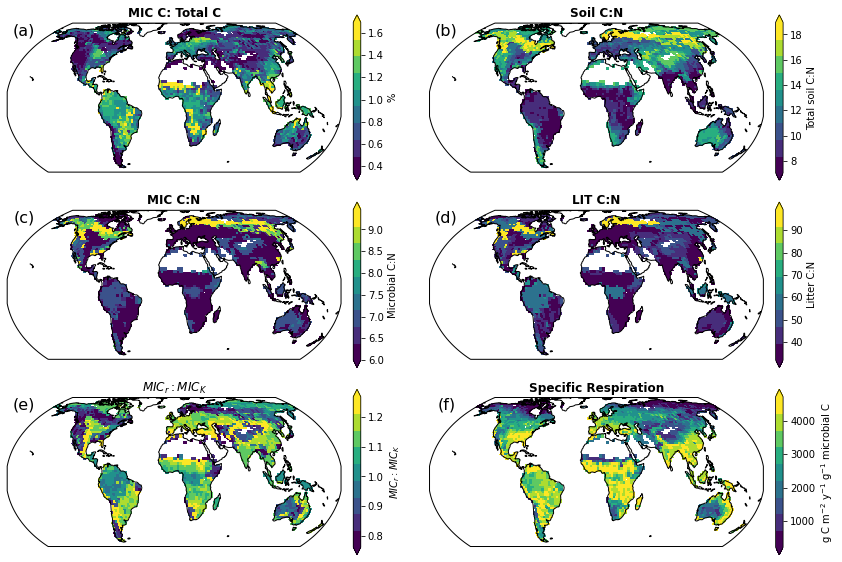

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_2_ZonalSOM.pdf --


<Figure size 432x288 with 0 Axes>

In [22]:
save = True
ncols = 2
nrows = 3
m2 = '$\mathregular{m^{-2}}$'
y1 = '$\mathregular{y^{-1}}$'
g1 = '$\mathregular{g^{-1}}$'
#  lists of variables, titles & labels
plotVars = ['relMIC','cnTOT','cnMIC',
            'cnLIT','MICrK','specRESP']
plotTitle = ['MIC C: Total C','Soil C:N','MIC C:N','LIT C:N',
             r'$MIC_{r}:MIC_{K}$', 
             'Specific Respiration']
plotLabel = ['%','Total soil C:N','Microbial C:N','Litter C:N',
             r'$MIC_{r}:MIC_{K}$', 
             'g C '+m2+' '+y1+' '+g1+' microbial C']

# create the plots
fig = plt.figure(figsize=(12,8))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=ccrs.EqualEarth(),
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ax.coastlines()
    tempPlot = ds[plotVars[i]].isel(time=slice(0,20),sim=3).sel(
        lat=slice(-60,83)).mean(dim='time')
    #convert daily fluxes to annual
    if i == 5:
        tempPlot = tempPlot*365 
    tempPlot.plot(
        ax=ax, robust=True, 
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={'label': plotLabel[i],  
                     "pad": 0.03,
                    },
        cmap=cm.get_cmap('viridis', 9),
    )
    ax.set_title(plotTitle[i],fontweight='bold')
    ax.annotate(panel[i], xy=(0.05, 0.95), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    i = i+1

plt.tight_layout()
plt.show()
if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_2_ZonalSOM.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;

**Figure 2** Initial characterization of soil states simulated by MIMICS-CN, averaged over initialization period (1901-1920).

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


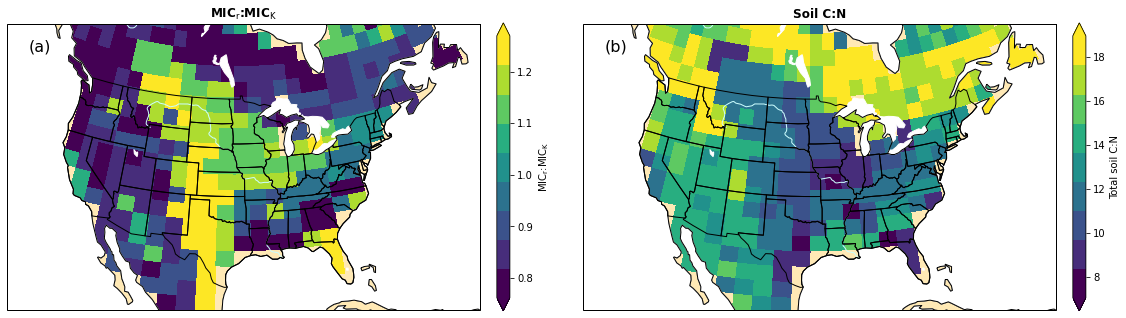

"if save == True:\n    fout = fin[0]+'figs/'+sim[0]+'_Fig_X_conusMaps.pdf'\n    plt.savefig(fout)\n    print(' -- wrote '+fout+' --') ;"

In [67]:
save = True
ncols = 2
nrows = 1
m2 = '$\mathregular{m^{-2}}$'
y1 = '$\mathregular{y^{-1}}$'
g1 = '$\mathregular{g^{-1}}$'
#  lists of variables, titles & labels
plotVars = ['MICrK','cnTOT',]
plotTitle = [r'MIC$_{\rm r}$:MIC$_{\rm K}$','Soil C:N']
plotLabel = [r'MIC$_{\rm r}$:MIC$_{\rm K}$','Total soil C:N']

# create the plots
fig = plt.figure(figsize=(16,4))
conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=conus_proj) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]


axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=conus_proj,
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ax.coastlines()
    tempPlot = ds[plotVars[i]].isel(time=slice(0,20),sim=3).sel(
        lat=slice(-60,83)).mean(dim='time')
    #convert daily fluxes to annual
    if i == 5:
        tempPlot = tempPlot*365 
    tempPlot.plot(
        ax=ax, robust=True, 
        transform=ccrs.PlateCarree(),  # this is important!
        cbar_kwargs={'label': plotLabel[i],  
                     "pad": 0.03,
                    },
        cmap=cm.get_cmap('viridis', 9),
    )
    ax.set_extent([-125,-65,20,55])
    ax.add_feature(cfeature.COASTLINE,zorder=2)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax.add_feature(cfeature.LAKES, facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')
    ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
    ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)

    ax.set_title(plotTitle[i],fontweight='bold')
    ax.annotate(panel[i], xy=(0.07, 0.92), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    i = i+1

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.show()

'''if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_X_conusMaps.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;'''

## Regrid observations for SI plots

In [134]:
dsXu_out = xr.Dataset({'lat': (['lat'], ds.lat),
                     'lon': (['lon'], ds.lon)})
GSDEoc_out = dsXu_out
HWSD_out   = dsXu_out 
NCSCD_out  = dsXu_out

In [137]:
import xesmf as xe  # to regrid observations

# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

XuRegridder = xe.Regridder(dsXu, dsXu_out, 'bilinear',periodic=True, reuse_weights=True)
GSDEregridder = xe.Regridder(GSDEoc, GSDEoc_out, 'bilinear',periodic=True, reuse_weights=True)
HWSDregridder = xe.Regridder(dsOBS['HWSD_SOCall'], HWSD_out, 'bilinear',periodic=True, reuse_weights=True)
NCSCDregridder = xe.Regridder(dsNCSCD, NCSCD_out, 'bilinear',periodic=True, reuse_weights=True)
#XuRegridder  # print basic regridder information.

Reuse existing file: bilinear_360x720_96x144_peri.nc
Reuse existing file: bilinear_1680x4320_96x144_peri.nc
Reuse existing file: bilinear_192x288_96x144_peri.nc
Reuse existing file: bilinear_268x1440_96x144_peri.nc


In [138]:
dsXu_out = XuRegridder(dsXu)
GSDEoc_out = GSDEregridder(GSDEoc)
HWSD_out = HWSDregridder(dsOBS['HWSD_SOCall'])
NCSCD_out = NCSCDregridder(dsNCSCD)

dsXu_out = dsXu_out.where(initNPP>minNPP)
GSDEoc_out = GSDEoc_out.where(initNPP>minNPP)
HWSD_out = HWSD_out.where(initNPP>minNPP)
NCSCD_out = NCSCD_out.where(initNPP>minNPP)

using dimensions ('lat', 'lon') from data variable BIOME as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable OC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


using dimensions ('lat', 'lon') from data variable NCSCD_SOC as the horizontal dimensions for this dataset.


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [152]:
HWSD_out.sel(lat=slice(-60,83))

<xarray.DataArray 'HWSD_SOCall' (lat: 76, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -59.68421 -57.789474 -55.894737 ... 80.52631 82.42105
    sim      <U5 'MIMcn'
Attributes:
    regrid_method:  bilinear

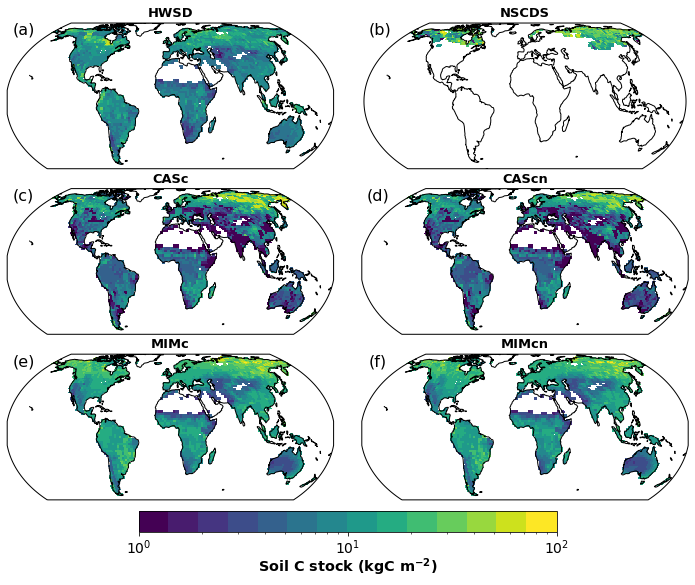

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_S2_ZonalSOM.pdf --


<Figure size 432x288 with 0 Axes>

In [250]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

#  lists of variables, titles & labels
plotVars = ['HWSD_SOCall','NCSCD_SOC','cTOT']
plotTitle = ['HWSD','NSCDS']+ simLabs
plotLabel = 'Soil C stock (kgC $\mathregular{m^{-2}}$)'
colorbar = [False,False,False,False,True,True]
# create the plots
fig = plt.figure(figsize=(10,8))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c,
                        projection=ccrs.EqualEarth(),
                        ) \
        for r in range(0, nrows) \
        for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    ax.coastlines()
    if i == 0:
        tempPlot = HWSD_out.sel(lat=slice(-60,83))
    if i == 1: 
        tempPlot = NCSCD_out[plotVars[i]].sel(lat=slice(-55,83))*1e-1
    if i > 1:
        tempPlot = ds[plotVars[2]].isel(time=slice(0,20),sim=(i-2)).sel(
        lat=slice(-60,83)).mean(dim='time')*1e-3
    cmap = cm.get_cmap('viridis', 14)
    norm = colors.LogNorm(vmin=1, vmax=100)
    tempPlot.plot(
        ax=ax, vmin=1,vmax=100,  
        norm=norm,
        transform=ccrs.PlateCarree(),  # this is important!
        add_colorbar=False,
        cmap=cmap,
    )
    ax.set_title(plotTitle[i],fontweight='bold',size=13)
    ax.annotate(panel[i], xy=(0.05, 0.95), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    
    i = i+1

# add a colorbar to the bottom of the plot    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.tight_layout()
cb = plt.colorbar(sm, ax=axes, orientation='horizontal', 
                  pad = 0.02,fraction=0.1,shrink=0.6, label = plotLabel,
                  ) ;
cb.ax.tick_params(labelsize=14)
cb.set_label(plotLabel, labelpad=-1, size='x-large',fontweight='bold')
plt.show()

if save == True:
    fout = fin[0]+'figs/'+sim[0]+'_Fig_S2_ZonalSOM.pdf'
    plt.savefig(fout)
    print(' -- wrote '+fout+' --') ;

## Code below to write out table of global means
- Table 1: Initial stocks & fluxes (1901-1920 means)
- Table 2: Change in global stocks and fluxes (mean 2000-2014)
GPP, NPP, HR, Soil C, microbial biomass, MIC:SOM, SOM C:N, microbial C:N

In [21]:
def globalSum ( varIn, area=ds.landarea.isel(sim=nsim-1) *1e6, timeC=1, conversion=1e-15, units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

def globalMean ( varIn, area=ds.landarea.isel(sim=nsim-1) *1e6, timeC=1, conversion=1, units=None, pt=False):
    "Global weighted mean"
    temp = varIn * area / area.sum()
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
#MIMcnANN['cgpp'].isel(time=slice(0,20)).mean('time')
print(np.round(globalSum(ds['cnpp'].isel(time=slice(0,20)).mean('time'),timeC=d2y, pt=False),1).values)

[42.  38.9 42.  37.6]


In [22]:
row_names = ['cgpp','cnpp','cresp','cTOT','cMICtot','relMIC','nNetMineralization','cnTOT','cnMIC']
col_names = simLabs
nrow = len(row_names)
ncol = len(col_names)
init_table = np.empty((nrow,ncol))
fin_table = np.empty((nrow,ncol))

for i in range(ncol):
    for j in range(nrow):
        din = ds.isel(sim=i,time=slice(0,20)).mean('time') 
        din2 = ds.isel(sim=i,time=slice(-20,None)).mean('time') 
        #convert fluxes appropriately
        if j <=2:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, pt=False),1).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, pt=False),1).values 
        # soil C stocks
        if j == 3:
            init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),0).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),0).values
        # MIC C stocks, Pg C
        if j == 4 :
            init_table[j,i] = np.round(globalSum(din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],pt=False),1).values
        if j == 5 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),3).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),3).values

        # net Mineraliztion, Tg N / year
        if j == 6 :
            init_table[j,i] = np.round(globalSum(din[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values
            fin_table[j,i] = np.round(globalSum(din2[row_names[j]],timeC=d2y, conversion=1e-12, pt=False),0).values

        # soil C:N
        if j == 7 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),1).values

        # MIC C:N
        if j == 8 :
            init_table[j,i] = np.round(globalMean(din[row_names[j]],pt=False),1).values
            fin_table[j,i] = np.round(globalMean(din2[row_names[j]],pt=False),1).values

change_table = fin_table - init_table
percent_table = 100* fin_table / init_table - 100
print('initial state')
print(pd.DataFrame(init_table,  index=row_names, columns=col_names))
print('Change by 2014')
print(pd.DataFrame(change_table,  index=row_names, columns=col_names))
pd.DataFrame(percent_table,  index=row_names, columns=col_names)

initial state
                     CASc  CAScn      MIMc     MIMcn
cgpp                106.1  106.1   106.100   106.100
cnpp                 42.0   38.9    42.000    37.600
cresp                42.0   38.9    42.000    37.600
cTOT                997.0  885.0  1582.000  1493.000
cMICtot               0.0    0.0    14.800    13.100
relMIC                0.0    0.0     0.925     0.877
nNetMineralization    0.0  887.0     0.000   857.000
cnTOT                 0.0   18.9     0.000    11.900
cnMIC                 0.0    0.0     0.000     6.800
Change by 2014
                    CASc  CAScn    MIMc    MIMcn
cgpp                15.5   15.5  15.500   15.500
cnpp                 5.6    5.1   5.600    5.400
cresp                4.9    4.5   5.700    5.300
cTOT                 6.0    6.0 -24.000  -12.000
cMICtot              0.0    0.0   1.200    1.200
relMIC               0.0    0.0   0.077    0.074
nNetMineralization   0.0  107.0   0.000  114.000
cnTOT                0.0   -0.1   0.000   -0.100


CASc      CAScn       MIMc      MIMcn
cgpp                14.608860  14.608860  14.608860  14.608860
cnpp                13.333333  13.110540  13.333333  14.361702
cresp               11.666667  11.568123  13.571429  14.095745
cTOT                 0.601805   0.677966  -1.517067  -0.803751
cMICtot                   NaN        NaN   8.108108   9.160305
relMIC                    NaN        NaN   8.324324   8.437856
nNetMineralization        NaN  12.063134        NaN  13.302217
cnTOT                     NaN  -0.529101        NaN  -0.840336
cnMIC                     NaN        NaN        NaN   0.000000

In [23]:
fout = fin[0]+'figs/HIST_Table1.xlsx'
pd.DataFrame(init_table,  index=row_names, columns=col_names).to_excel(fout)  

fout = fin[0]+'figs/HIST_Table2.xlsx'
pd.DataFrame(change_table,  index=row_names, columns=col_names).to_excel(fout)  
print(' -- wrote '+fout+' --')


 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/HIST_Table2.xlsx --


### Look at changes over historical period

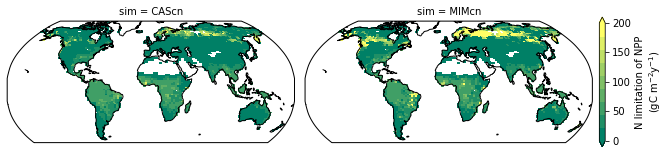

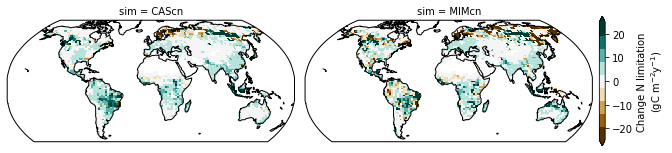

In [24]:
from matplotlib import cm
ds['Nlimit'] = ds['cnpp'].isel(sim=0) - ds['cnpp']
ds['Nlimit'].attrs['long_name'] = 'N limitation of NPP'
ds['Nlimit'].attrs['units'] = ds['cnpp'].attrs['units']
fg = (ds['Nlimit']*365).isel(time=0,sim=CNsim).sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = 0, vmax=200,
    cmap=cm.get_cmap('summer', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'N limitation of NPP\n'+r'(gC $\mathregular{m^{-2} y^{-1}}$)',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())


ds['relNlimit'] = ds['cnpp']/ ds['cnpp'].isel(sim=0)
ds['relNlimit'].attrs['long_name'] = 'relative N limitation of NPP'
ds['relNlimit'].attrs['units'] = 'fraction'
#ds['relNlimit'].isel(time=0, sim=CNsim).plot(x="lon", y="lat", col="sim", robust=True,
#                                             figsize=[12,4],col_wrap=len(CNsim)); 

# look at spatial maps of changes in N limitation 1995:2014 mean - 1901:1920 mean
temp  = ((ds.isel(time=slice(-20,None)).mean(dim='time') -
          ds.isel(time=slice(0,20)).mean(dim='time')) )
fg = (temp['Nlimit']*365).isel(sim=CNsim).sel(lat=slice(-58,80)).plot(
    x='lon', y='lat',col='sim',col_wrap=2, figsize=[10,2.3],
    vmin = -25, vmax=25,    
    cmap=cm.get_cmap('BrBG', 9),
    cbar_kwargs={
        #"orientation": "horizontal",
        "label": 'Change N limitation\n'+r'(gC $\mathregular{m^{-2} y^{-1}}$)',
        "pad": 0.01,
    },
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.Robinson(),
    },
) ;
fg.map(lambda: plt.gca().coastlines())
fg.set_titles() ;

### Changes in high latitude N limitation for each model look pretty different, 
reflecting cTOT losses & increases in N mineralizatiton rates


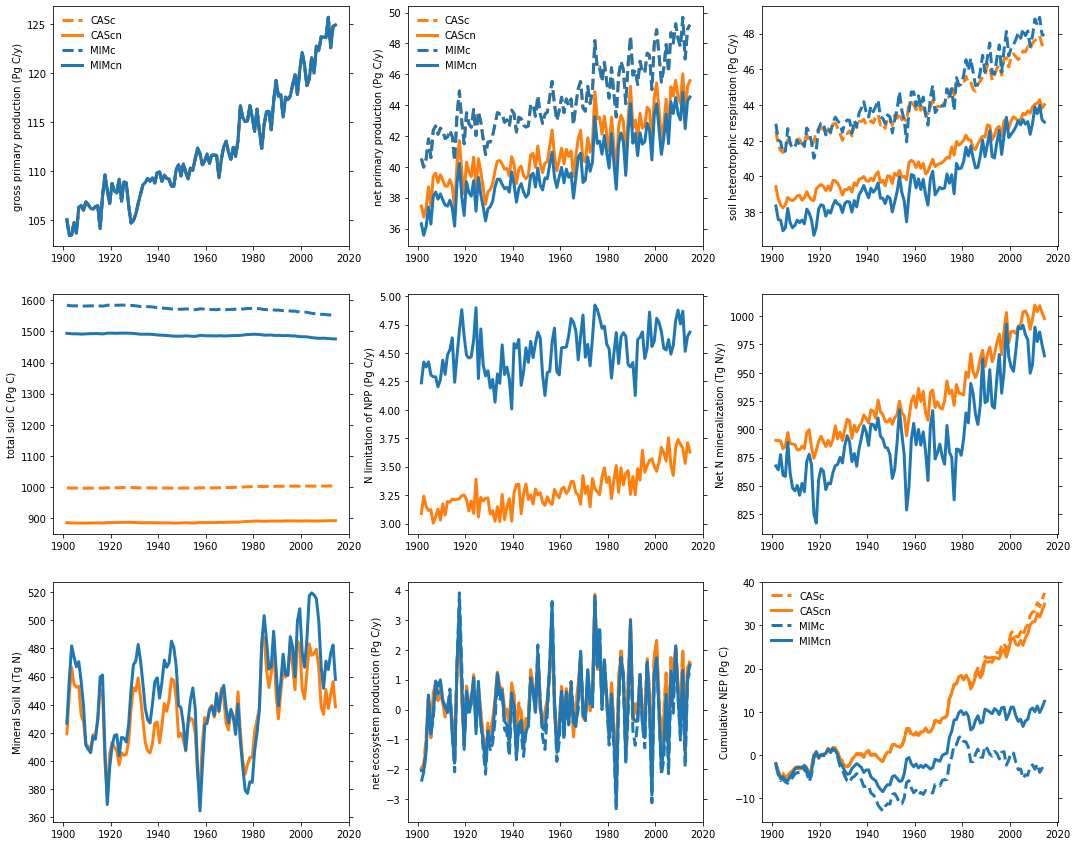

In [25]:
model = simLabs
var = ['cgpp','cnpp','cresp','cTOT','Nlimit',
       'nNetMineralization','nMineral','NEP']
nvar  = len(var)
timeC = [365,365,365,1,365,
         365,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,
              1e-12,1e-12,1e-15]
units = ['(Pg C/y)','(Pg C/y)','(Pg C/y)','(Pg C)','(Pg C/y)',
         '(Tg N/y)','(Tg N)','(Pg C/y)']

fig = plt.figure(figsize=[18,15])
        
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(ds[var[i]].attrs['long_name']+' '+units[i])
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 4 or i == 5 or i == 6:
                temp = temp*np.nan
        ax.plot(ds.time, temp, lw=3,color=color[j],linestyle=linestyle[j])        
    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
for j in range(len(model)):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
ax.legend(labels=model, frameon = False, fontsize='medium');

**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Both N models have a higher cumulative NEP, but changes w/ MIMICS-CN are greater.
- Implies longer MRT of soil C pools in CN models, relative to their C-only counterparts 
- **OR** larger increases in NPP from regions experiencing N limitation (relative to the C only model). 
- From change time series below, seems like the biggest differences are in HR (not NPP)

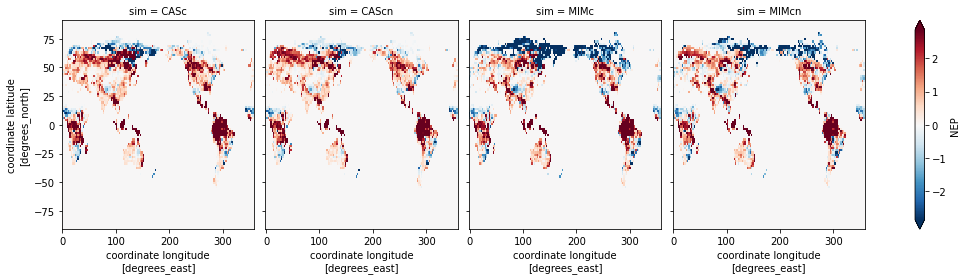

In [26]:
cumNEP = ds['NEP'].cumsum(dim='time').isel(time=-1)
cumNEP.plot(x="lon", y="lat", col="sim", robust=True,figsize=[15,4],col_wrap=nsim);


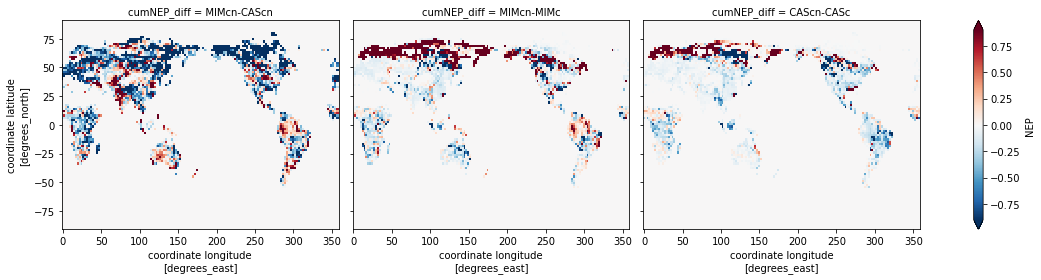

In [27]:
#Differences in NEP CN-Conly
MIMcn_CAScn  = cumNEP.isel(sim=3)-cumNEP.isel(sim=1)
MIMcn_MIMc   = cumNEP.isel(sim=3)-cumNEP.isel(sim=2)
CAScn_CASc   = cumNEP.isel(sim=1)-cumNEP.isel(sim=0)

cn_c = xr.concat([MIMcn_CAScn,MIMcn_MIMc,CAScn_CASc], 'cumNEP_diff')
cn_c['cumNEP_diff'] = ['MIMcn-CAScn','MIMcn-MIMc','CAScn-CASc']

g_simple = cn_c.plot(x="lon", y="lat", col="cumNEP_diff", robust=True,
                                   col_wrap=3,figsize=[16,4],cmap="RdBu_r")


**Figure y** N effects on cumulative NEP (1901-2014) 
- MIMICS with less net land uptake than CASA (left) 
- Biggest differences in cumulative NEP in MIMICS across arctic and boreal forests (middle), 
- CASA effects of N limitation on cumulative land C uptake are weaker (right) 

Are changes  really just reflecting the degree of initial N limitation in CN models?

# Changes from initial conditions

['NEP']


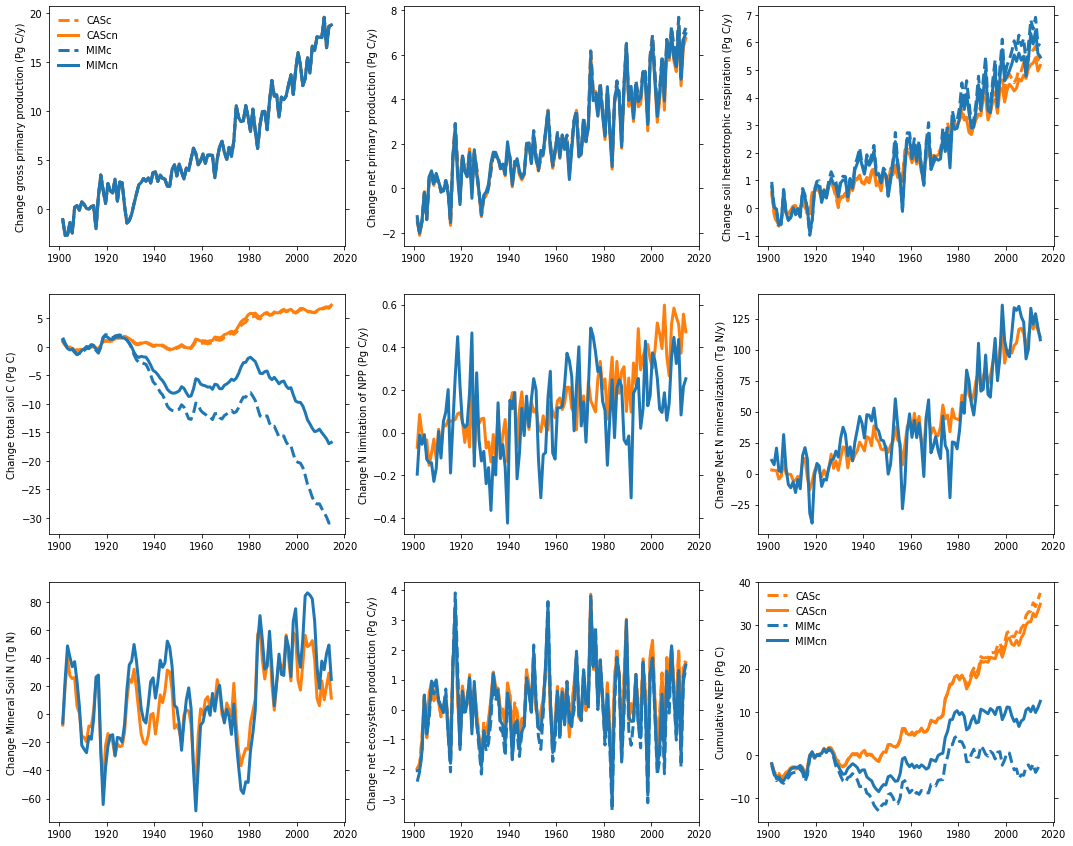

In [43]:
model = simLabs
fig = plt.figure(figsize=[18,15]);
t = 20
    
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ds[var[i]].attrs['long_name']+' '+units[i])
    for j in range(len(model)):
        temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## zero out N fluxes for C-only runs
        if j == 2 or j == 0:
            if i == 4 or i == 5 or i == 6:
                temp = temp*np.nan
                
        ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                lw=3,color=color[j],linestyle=linestyle[j])        
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
for j in range(nsim):
    ax.plot(ds.time, np.cumsum(globalSum(ds[var[i]].isel(sim=j),
                               timeC=timeC[i],conversion=conversion[i])), 
            lw=3,color=color[j],linestyle=linestyle[j])        
ax.legend(labels=model, frameon = False, fontsize='medium');

**Figure X** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Does this influence N limitation in regions where SOM turnover is accelerating?
- Greater IAV of C&N fluxes from MIMICS, it would be interesting to see the source & driver of this variability (temp, moisture, productivity).

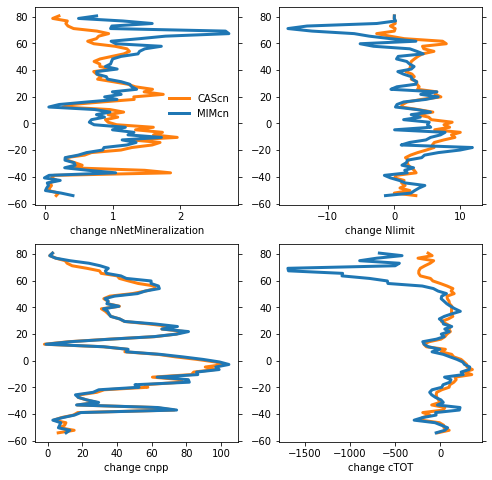

In [47]:
# look at zonal mean of changes in N limitation 1995:2014 mean - 1901:1920 mean
temp  = ((ds.isel(time=slice(-20,None)).mean(dim='time') -
          ds.isel(time=slice(0,20)).mean(dim='time')) )

plotVar = ['nNetMineralization','Nlimit','cnpp','cTOT']
#dHist.mean(dim='lon').isel(deltaHist=i)
fig = plt.figure(figsize=[8,8]);
t = 20
model = ['CAScn','MIMcn'] 
for i in range(len(plotVar)):
    ax = fig.add_subplot(2, 2, (i+1))
    for j in CNsim:  #loop over simulations
        x = temp[plotVar[i]].mean(dim='lon').isel(sim=j)
        #convert daily to annual flux
        if i < 3: x = x*365
        ax.plot(x, temp.lat, 
                lw=3,color=color[j],linestyle=linestyle[j])
    ax.set_xlabel("change "+plotVar[i])
    ax.yaxis.set_ticks_position('both')
    if i==0:
        ax.legend(labels=model, frameon = False, fontsize='medium')


In [48]:
#temp

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, sim: 4)
Coordinates:
  * sim                  (sim) object 'CASc' 'CAScn' 'MIMc' 'MIMcn'
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
Data variables:
    day                  (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    IGBP_PFT             (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    landarea             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cellMissing          (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cellid               (sim, lat, lon) float64 nan nan nan nan ... nan nan nan
    cLITm                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cLITs                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cMICr                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cMICk                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cSOMa                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cSOMc                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cSOMp                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cHresp               (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cSOMpIn              (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cLitInput_metb       (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cLitInput_struc      (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cOverflow_r          (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cOverflow_k          (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nLITm                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nLITs                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nMICr                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nMICk                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nSOMa                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nSOMc                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nSOMp                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    DIN                  (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nLitInput_metb       (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nLitInput_struc      (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    thetaLiq             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    thetaFrzn            (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    fW                   (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cresp                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cnpp                 (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cgpp                 (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cleaf                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nleaf                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cwood                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nwood                (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    cfroot               (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nfroot               (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    clitmetb             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nlitmetb             (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    clitstr              (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nlitstr              (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    clitcwd              (sim, lat, lon) float32 nan nan nan nan ... nan nan nan
    nlitcwd              (sim, lat, lo

### changes in total pools

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_4_Cchanges_HIST.pdf --


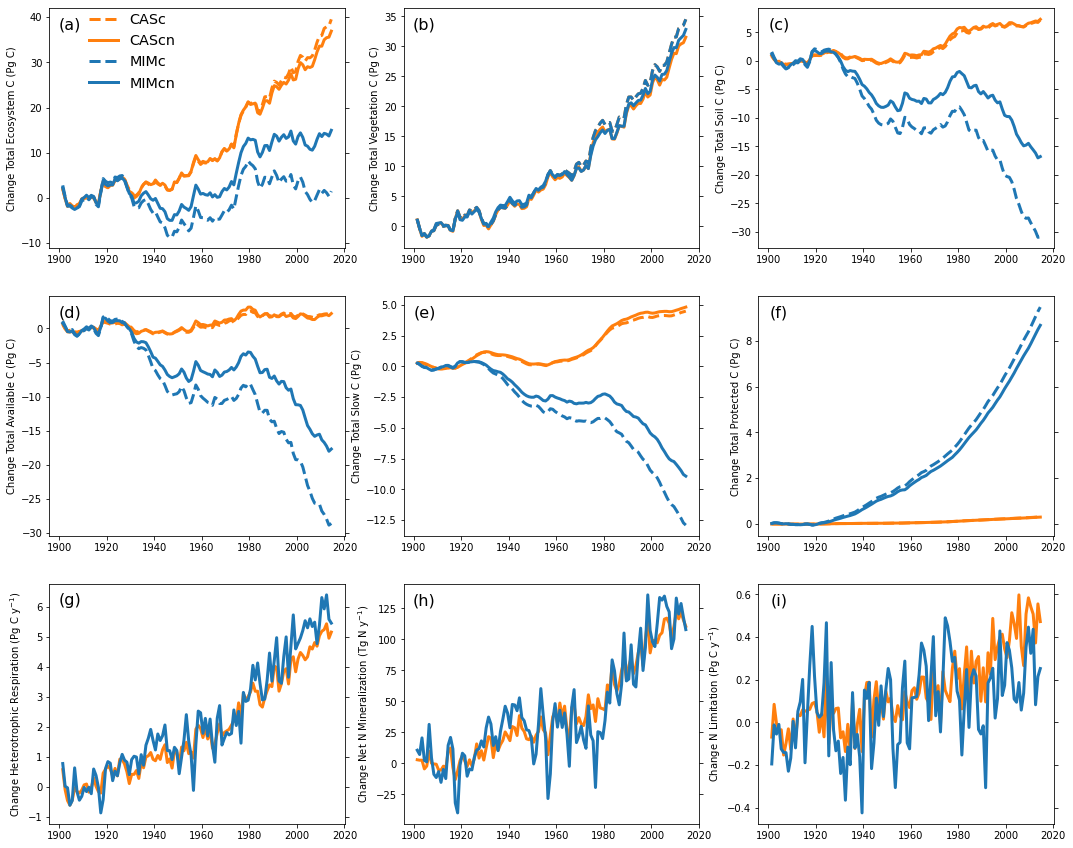

In [57]:
var = ['cECO','cVEG','cTOT','cAVAIL','cSOMc','cSOMp',
       'cresp','nNetMineralization','Nlimit']
ylab = ['Total Ecosystem C','Total Vegetation C','Total Soil C',
        'Total Available C','Total Slow C','Total Protected C',
        'Heterotrophic Respiration','Net N Mineralization','N Limitation']
timeC = [1,1,1,1,1,1,365,365,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-15,1e-12,1e-15]
units = ['(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C)',
         '(Pg C $\mathregular{y^{-1}}$)',
         '(Tg N $\mathregular{y^{-1}}$)','(Pg C $\mathregular{y^{-1}}$)']
model = simLabs

fig = plt.figure(figsize=[18,15]);

# loop over variables 
for i in range(len(var)):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Change '+ylab[i]+' '+units[i])
    ax.annotate(panel[i], xy=(0.07, 0.93), xycoords=ax.transAxes, 
                ha='center', va='center',fontsize=16)    

    # loop over simulations
    for j in range(nsim):  
        if var[i] == 'cAVAIL':
            if j < 2:
                temp = globalSum((ds['clitmetb']+ds['clitstr']+ds['csoilmic']).isel(
                    sim=j),timeC=timeC[i],conversion=conversion[i])
            else: 
                temp = globalSum((ds['cLITm']+ds['cLITs']+ds['cSOMa']).isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
                            
        else:
            temp = globalSum(ds[var[i]].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
        ## changes in passive pool for CASA-only runs
        if j < 2 :
            if i == 4:
                temp = globalSum(ds['csoilslow'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
            if i == 5:
                temp = globalSum(ds['csoilpass'].isel(sim=j),
                         timeC=timeC[i],conversion=conversion[i])
                
        if i < 6:
            ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                    lw=3,color=color[j],linestyle=linestyle[j]) 
        else: #Skip N variables for C only models
            if j == 1 or j == 3:
                ax.plot(ds.time, (temp - temp.isel(time=slice(0,t)).mean()), 
                        lw=3,color=color[j],linestyle=linestyle[j]) 
            
    if i==0:
        ax.legend(labels=model, frameon = False, bbox_to_anchor=[0.28, 0.82],
                  loc='center',fontsize='x-large')

fout = fin[0]+'figs/'+sim[0]+'_Fig_4_Cchanges_HIST.pdf'
plt.savefig(fout)
print(' -- wrote '+fout+' --')  

**Fig 4** Changes in total ecosystem, Veg, and SOM pools (top row), 
Changes in available, slow, and passive C.  
- It's potentially useful to look at changes and IAV of Nmineralization and Nlimitation, but maybe that's better in another figure or with daily data?

In [58]:
# ratio of respiration:mineralization over time
var = ['cresp','nNetMineralization']
ds['HR:Min'] = (ds[var[0]]/ds[var[1]])

In [59]:
# Zonal mean of changes by end of simulation
dsZon = (ds - ds.isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

## plot zonal mean over time

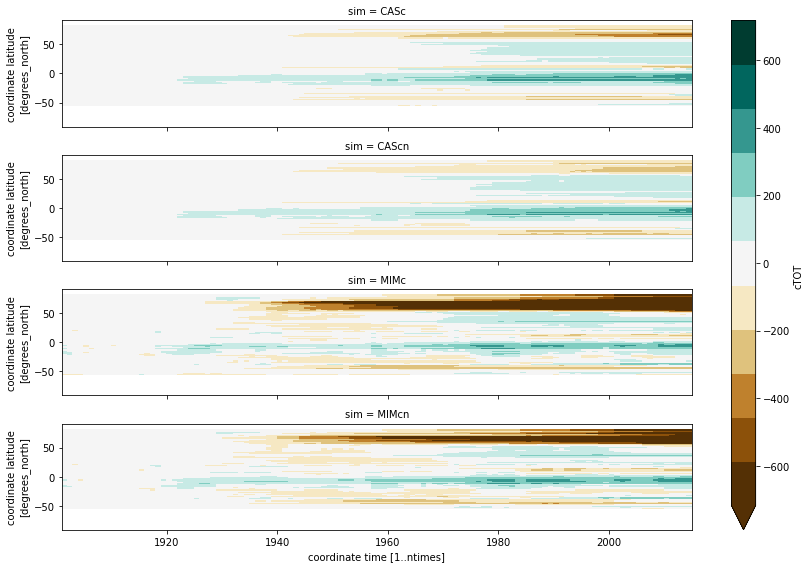

In [60]:
from matplotlib import cm

dsZon['cTOT'].plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,8],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 11) ) ; 

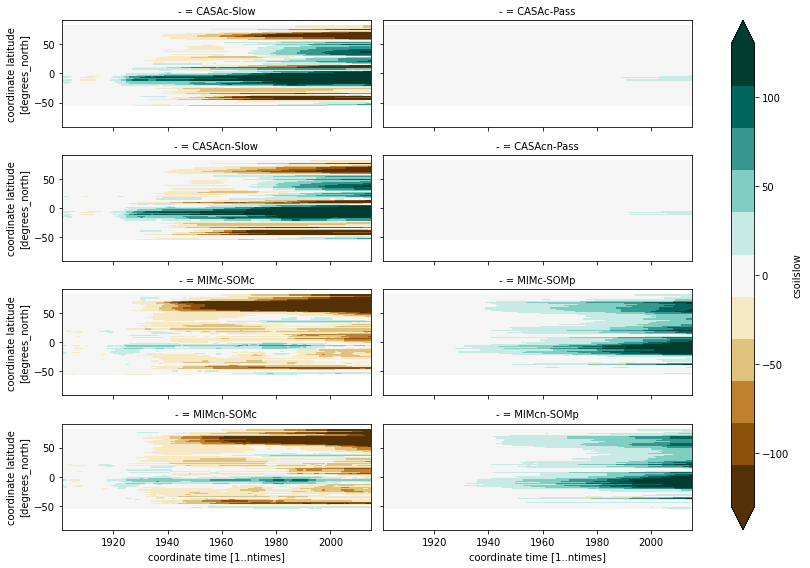

In [61]:
temp = xr.concat([dsZon.isel(sim=0)['csoilslow'], dsZon.isel(sim=0)['csoilpass'],
                 dsZon.isel(sim=1)['csoilslow'], dsZon.isel(sim=1)['csoilpass'],
                 dsZon.isel(sim=2)['cSOMc'], dsZon.isel(sim=2)['cSOMp'],
                 dsZon.isel(sim=3)['cSOMc'], dsZon.isel(sim=3)['cSOMp']],
                 '-')
temp['-'] = ['CASAc-Slow' ,'CASAc-Pass','CASAcn-Slow','CASAcn-Pass',
              'MIMc-SOMc' ,'MIMc-SOMp' ,'MIMcn-SOMc' ,'MIMcn-SOMp']                 
temp.plot(
    x="time", y="lat", col="-", robust=True,figsize=[12,8],col_wrap=2,
    cmap=cm.get_cmap('BrBG', 11) ) ; 

### Plot maps of where fluxes are changing

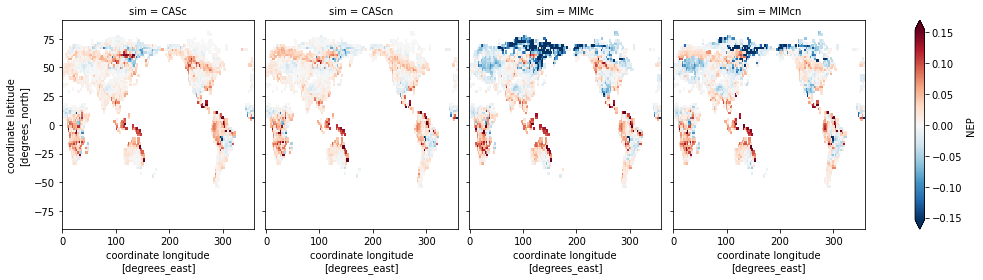

In [62]:
var='NEP'
(ds[var].isel(time=slice(-20,None)).mean(dim='time')-
 ds[var].isel(time=slice(  0,20  )).mean(dim='time')).plot(
    x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim);

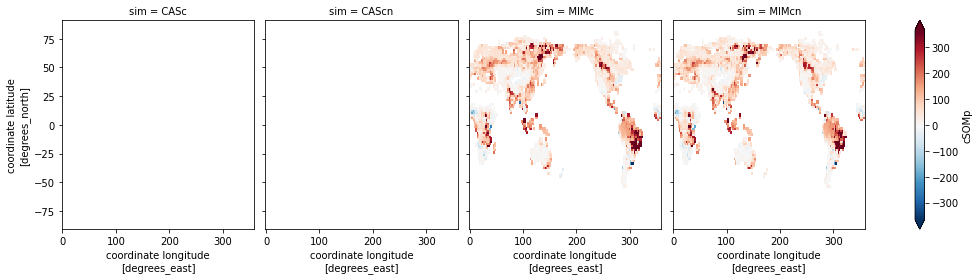

In [63]:
var = ['cresp','tsoilC','nNetMineralization','cSOMp','cTOT','fW']
tempMIM = (ds[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           ds[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempMIM.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

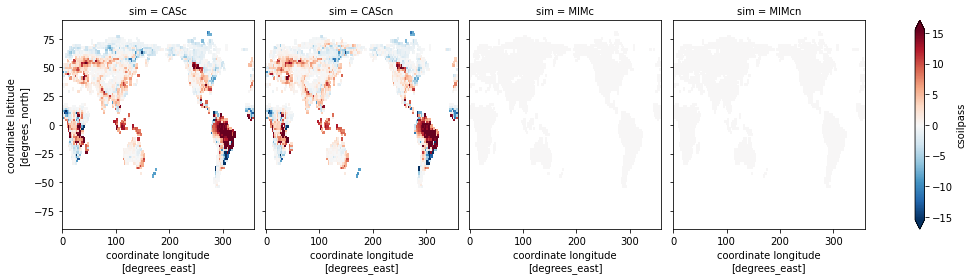

In [64]:
var = ['cresp','tsoilC','nNetMineralization','csoilpass','cTOT','fW']
tempCAS = (ds[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           ds[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempCAS.plot(x="lon",y="lat",col="sim",robust=True,figsize=[15,4],
    col_wrap=nsim) ;

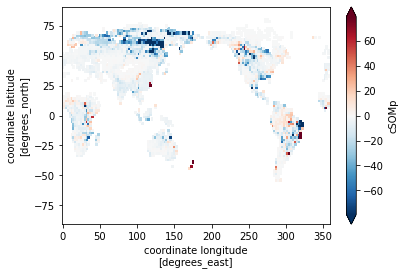

In [65]:
(tempMIM.isel(sim=3) - tempMIM.isel(sim=2)).plot(robust=True);
# not sure what a meaningful way to look at these changes may be?

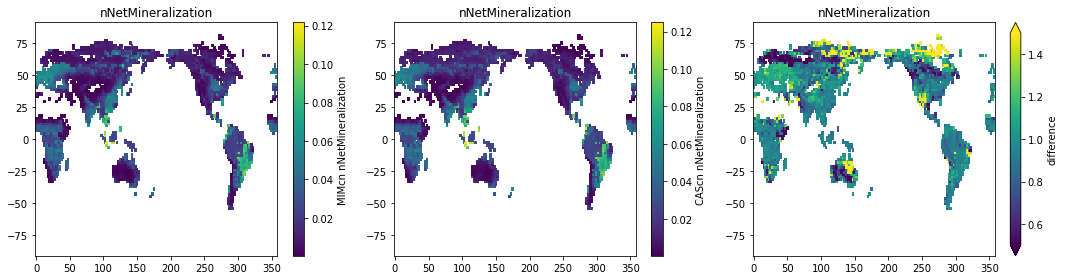

In [66]:

ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['nNetMineralization']
plotTitle = ['nNetMineralization']
plotLable = ['nNetMineralization']

# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        ds[plotVars[j]].isel(time=-1,sim=3).plot(ax=ax, cbar_kwargs={'label': 'MIMcn '+plotLable[j]})
    if i == 1:
        ds[plotVars[j]].isel(time=-1,sim=1).plot(ax=ax,  cbar_kwargs={'label': 'CAScn '+plotLable[j]})
    if i == 2:
        (ds[plotVars[j]].isel(time=-1,sim=3)/  \
         ds[plotVars[j]]).isel(time=-1,sim=1).plot(
            ax=ax, vmax=1.5,vmin=0.5, cbar_kwargs={'label': 'difference'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()

#MIMcnANN['HR:Min'].isel(time=0).plot(robust=True);

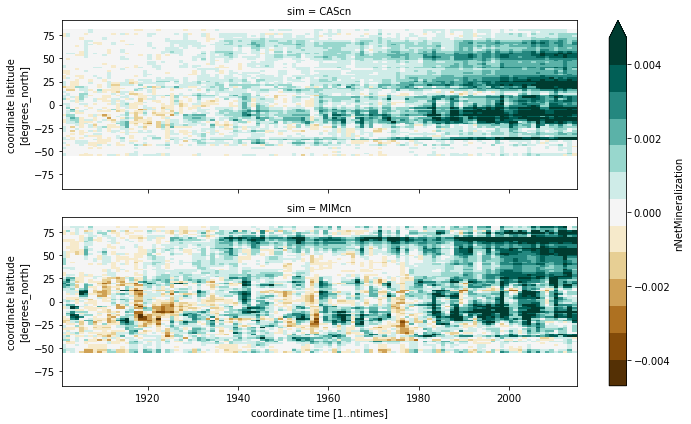

In [67]:
#changes in mineralization over time in both models
var2 = ['cnpp','cresp','NEP','cTOT','nNetMineralization','HR:Min','cnTOT']

dsZon[var2[4]].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[10,6],col_wrap=1, 
                   cmap=cm.get_cmap('BrBG', 13) ) ;  


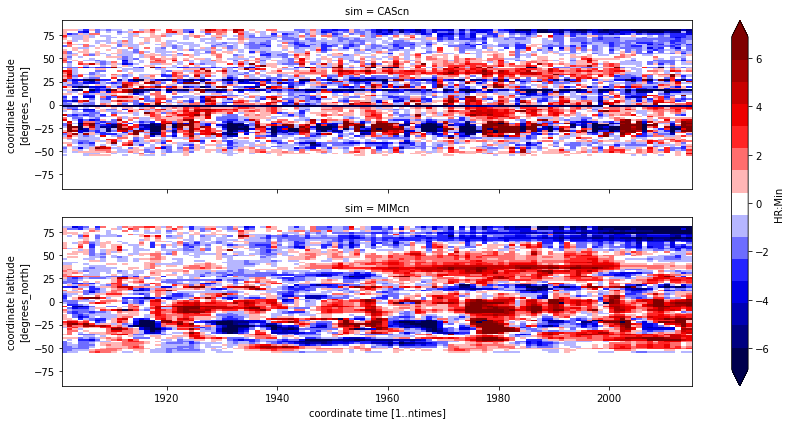

In [68]:
# Basically show the C:N of microbial spilling
dsZon['HR:Min'].isel(sim=CNsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[12,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

**Figure X.** Zonal mean changes in N mineralization rates simulated by MIMICS-cn & CASA-cn


### Zonal mean changes, relative to C-only model

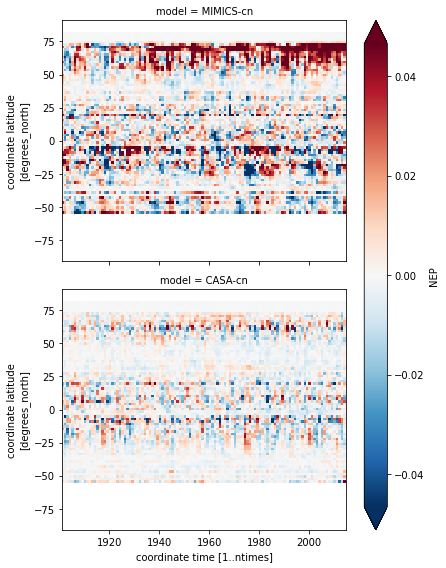

In [69]:
#changes, relative to the C-only model
var2 = ['cnpp','cresp','NEP','cTOT']
ds2 = ds[var2].copy('deep')

dMIMcn = ((ds2.isel(sim=3)-ds2.isel(sim=(3-1)))).mean(dim='lon')
dCAScn = ((ds2.isel(sim=1)-ds2.isel(sim=(1-1)))).mean(dim='lon') 

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIMcn,dCAScn],dim=model)

#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t[var2[2]].plot(x='time', y='lat',col='model',col_wrap=1, figsize=[6,8],robust=True);#vmax=5e-3,vmin=-5e-3);



**Figure X.** Zonal mean changes in rates simulated by MIMICS-cn 

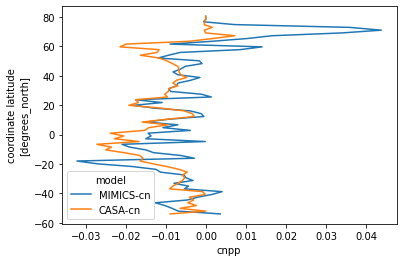

In [70]:
## Change in N limitation ove time
(t[var2[0]].isel(time=slice(-20,None)).mean('time')- \
 t[var2[0]].isel(time=slice(  0,20  )).mean('time')).plot(y='lat',hue='model') ;

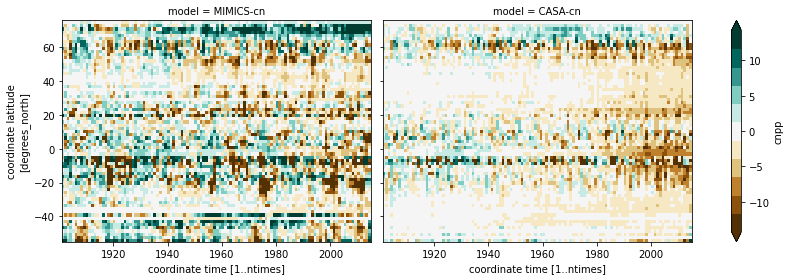

In [71]:
v=0
d_t = (t - t.isel(time=slice(0,20)).mean('time'))
d_t['cnpp'].attrs['long_name'] = 'Change in N limitation of NPP'
#d_t['cnpp'] = d_t['cnpp'] * -1 

simple = (d_t[var2[v]]*365).sel(lat=slice(-55,75)).plot(
    x='time', y='lat',col='model',col_wrap=2, 
    figsize=[12,4],robust=True, cmap=cm.get_cmap('BrBG', 11))

# N limtitation data are pretty noisy, especially for MIMICS
## try rolling mean to smooth our resutls and see clearer trends


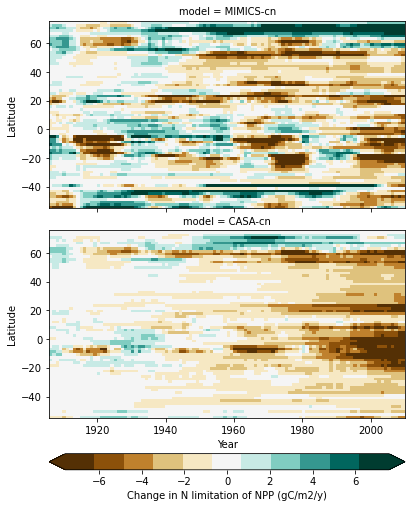

In [72]:
v=0
fg = ((d_t[var2[v]]*365).rolling(
    time=10, center=True).mean()).sel(
    lat=slice(-55,75),time=slice(1906,2010)).plot(
    x='time', y='lat',col='model',col_wrap=1, figsize=[6,8],robust=True,
    cmap=cm.get_cmap('BrBG', 11),
    cbar_kwargs={
        "orientation": "horizontal",
        "label": d_t[var2[v]].attrs['long_name']+' (gC/m2/y)',
        "pad": 0.07}
)
fg.set_xlabels('Year')
fg.set_ylabels('Latitude') ;


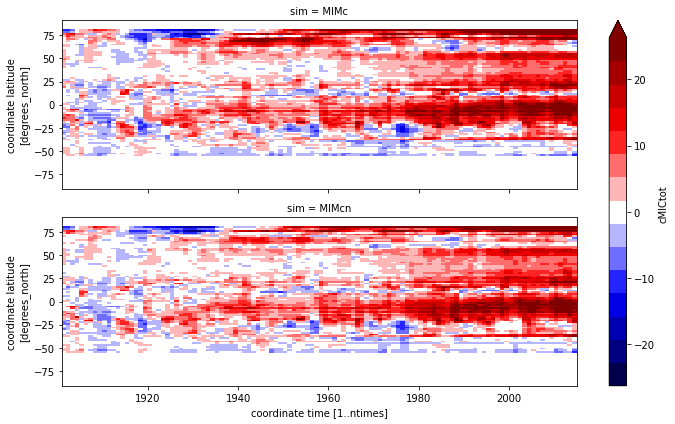

In [73]:
# Mimics specifics rsults
# var = ['specRESP','cMICtot','MICrK','cnMIC']
dsZon['cMICtot'].isel(sim=MIMsim).plot(x="time", y="lat", col="sim", 
                   robust=True,figsize=[10,6],col_wrap=1, 
                   cmap=cm.get_cmap('seismic', 15) ) ; 

### Look at environmental controls over soil C:N in MIMICS

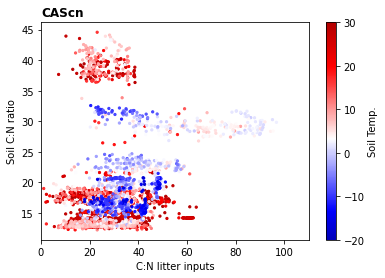

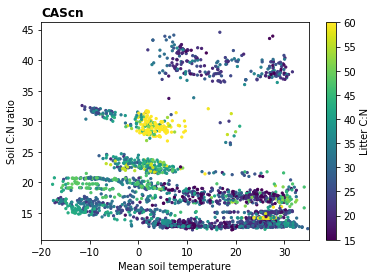

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_3a.pdf --


<Figure size 432x288 with 0 Axes>

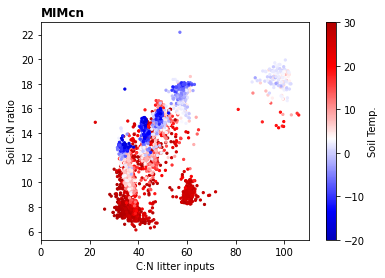

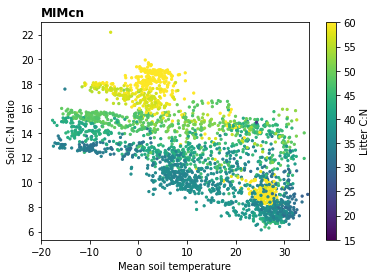

 -- wrote /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3_KO4/OUTPUT_CN/HIST/figs/MIMICS_mod5_GSWP3_KO4_Fig_3b.pdf --


<Figure size 432x288 with 0 Axes>

In [292]:
model = simLabs
sub = ['a','b']
j = 0
for i in CNsim:
    ds_1 = ds.isel(time=0, sim=i)
    if i == 1:
        ds_1['cnLIT'] = (ds_1.cLitInptMet + ds_1.cLitInptStruc) / \
                         (ds_1.nLitInptMet + ds_1.nLitInptStruc)
    else:
        ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / \
                         (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
    ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

    color_by = ds_1.tsoilC
    label = 'Soil Temp.'  # Need to rename if 'color_by' is changed

    fig, ax = plt.subplots()
    s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',                   # Plot circles
                  # alpha = 0.2,
                   cmap = utils.truncate_colormap(
                       cmapIn='seismic', minval=.15, maxval=.9),
                   vmin = -20,            # Min value
                   vmax = 30)             # Max value

    # Mappable 'maps' the values of s to an array of RGB colors 
    #  defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
    plt.ylabel('Soil C:N ratio')
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    ax.set_xlim(0, 110)
    plt.show();

    color_by = ds_1['cnLIT'] 
    label = 'Litter C:N'     
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
    fig, ax = plt.subplots()
    s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
                   c=color_by,
                   s=5,
                   marker='o',          # Plot circles
                   #alpha = 0.2,
                   #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),
                   #plt.cm.seismic, # Color pallete coolwarm
                   vmin = 15,           # Min value
                   vmax = 60)           # Max value

    # Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
    cbar = plt.colorbar(mappable = s, ax = ax)   
    cbar.set_label(label)
    plt.xlabel('Mean soil temperature')
    plt.ylabel('Soil C:N ratio')
    plt.title(model[i],loc='left', fontsize='large', 
              fontweight='bold')
    ax.set_xlim(-20, 35)
    plt.show();
    
    if save == True:
        fout = fin[0]+'figs/'+sim[0]+'_Fig_3'+sub[j]+'.pdf'
        plt.savefig(fout)
        print(' -- wrote '+fout+' --') ;
    j = j+1

**Figure 3** Temperature and litter stoichiometry interact to determine the soil C:N ratios that are simulated by MIMICS-CN. Points represent the gridcell mean annual stoichiometry of litterfall C:N fluxes that are simulated by the CASA-CNP vegetation model and resulting soil C:N ratios that are simulated by MIMICS.  The color of each point indicates mean annual soil temperature simulated by over the spin-up period (1901-1920). 


## Take a look at SoDaH data

In [5]:
import getEDI
# created function from .py script provided with SoDaH data

dt1 = getEDI.get_SoDaH_data()
#dt1
# pretty high soil CN values reported
# How do we handle depth reps at sites?
# poor alignment of soilCN and litCN
dt = dt1.where(dt1.lyr_c_to_n<50)

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (6,7,8,9,10,11,12,15,18,22,25,27,28,30,31,32,33,34,35,36,45,51,52,57,58,59,63,64,67,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,86,87,88,89,90,104,115,133,134,135,144,146,147,152) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


google_dir             data_file curator_PersonName  \
0          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
1          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
2          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
3          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
4          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
...                ...                   ...                ...   
293587  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293588  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293589  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293590  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293591  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   

           curator_organization             curator_email modification_date  \
0       Oregon State University  piersond@oregonstate.edu        2018-03-07   
1       Oregon State University  piersond@oregonstate.edu        2018-03-07   
2       Oregon State University  piersond@oregonstate.edu        2018-03-07   
3       Oregon State University  piersond@oregonstate.edu        2018-03-07   
4       Oregon State University  piersond@oregonstate.edu        2018-03-07   
...                         ...                       ...               ...   
293587  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293588  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293589  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293590  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293591  Oregon State University  piersond@oregonstate.edu        2019-09-22   

                author_PersonName                     author_email  \
0                   Derek Pierson         piersond@oregonstate.edu   
1                   Derek Pierson         piersond@oregonstate.edu   
2                   Derek Pierson         piersond@oregonstate.edu   
3                   Derek Pierson         piersond@oregonstate.edu   
4                   Derek Pierson         piersond@oregonstate.edu   
...                           ...                              ...   
293587  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293588  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293589  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293590  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293591  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   

            author_orcid_id addit_contact_person  ... frc_oc frc_n_tot  \
0       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
1       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
2       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
3       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
4       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
...                     ...                  ...  ...    ...       ...   
293587                  NaN       Christy Lowney  ...    NaN       NaN   
293588                  NaN       Christy Lowney  ...    NaN       NaN   
293589                  NaN       Christy Lowney  ...    NaN       NaN   
293590                  NaN       Christy Lowney  ...    NaN       NaN   
293591                  NaN       Christy Lowney  ...    NaN       NaN   

       frc_c_to_n bd_methods_notes layer_thick_calc lyr_soc_stock_calc  \
0             NaN              NaN             10.0            3315.26   
1             NaN              NaN             10.0            5399.70   
2             NaN              NaN             10.0            2964.30   
3             NaN              NaN             10.0            4702.70   
4             NaN              NaN             10.0            6266.44   
...           ...              ...              ...                ...   
293587    

In [38]:
#print(dt1.lit_cn.groupby(dt1.location_name.unique()))
#plt.plot(dt1.location_name,dt1.lit_cn)

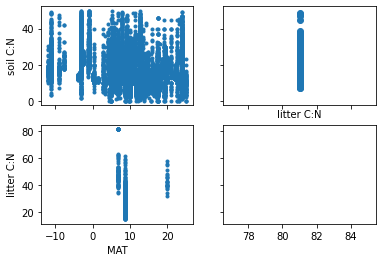

In [39]:


#plt.title('SoDaH',loc='left', fontsize='large', 
#          fontweight='bold')

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row')
# marker symbol
axs[0, 0].plot(dt.mat,dt.lyr_c_to_n,'.')
axs[0, 0].set_ylabel('soil C:N')

axs[0, 1].scatter(dt.lit_cn,dt.lyr_c_to_n)
axs[0, 1].set_xlabel('litter C:N')

axs[1, 0].plot(dt1.mat,dt1.lit_cn,'.') 
axs[1, 0].set_ylabel('litter C:N')
axs[1, 0].set_xlabel('MAT') ;

#axs[1, 1].plot.hist(dt.lyr_c_to_n,'.')


-----------
### Annual cycle of fluxes
This can be done for grid cells, or zonally

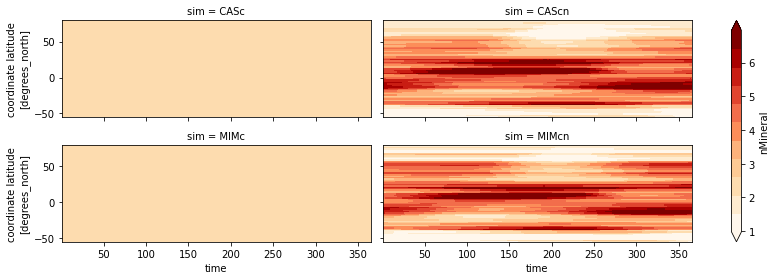

In [282]:
dsDay['Nlimit'] = dsDay['cnpp'] - dsDay['cnpp'].isel(sim=0)

var = ['cMICtot','nMineral','cresp',
       'nNetMineralization','MICrK','cnMIC','cnpp','NEP',
       'Nlimit']
v = 1
dsDay.isel(time=slice(0,365))[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", col="sim", robust=True,
    cmap=cm.get_cmap('OrRd', 11), #BrBG for NEP
    figsize=[12,4],col_wrap=2);

- Above: Positive NEP = land C uptake, 
Negative = release to atmosphere
- Below: red = MIMICS > CASA

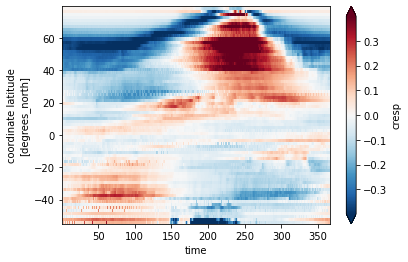

In [254]:
## Mimics - CASA
MCdiff = dsDay.isel(sim=3) - dsDay.isel(sim=1)
MCdiff.isel(time=slice(0,365))[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", robust=True,
    figsize=[6,4]);

In [255]:
# try looking at annual cycle of fluxes from 40-60 N

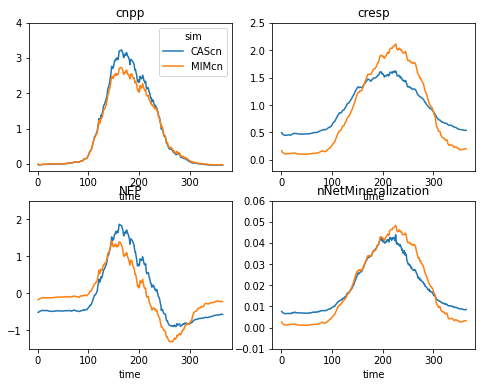

In [291]:
plt.figure(figsize=[8,6])
latmin, latmax = 50,60
0
ymin = [None,-0.2,-0.2,-1.5,-0.01,0.01,1]
ymax = [None,4   ,2.5 ,2.5 , 0.06,-0.5 ,6]
j = 1
for i in [6,2,7,3]:#,8,3,1]:
    temp = globalMean(dsDay[var[i]].sel(lat=slice(latmin, latmax)), 
                     area=ds.landarea.isel(sim=nsim-1).sel(lat=slice(latmin, latmax)) *1e6, 
                     timeC=1, conversion=1, units='gC/m2/d', pt=False)
    plt.subplot(2, 2, j)
    if j == 1: legend = True
    else: legend = False
    temp.isel(time=slice(0,365),sim=CNsim).plot(
        x='time', hue="sim",add_legend=legend) ;
    plt.title(var[i])
    plt.ylim(ymin[j], ymax[j])

    #plt.subplot(2, 5, (j+5))
    #temp.isel(time=slice(365,None),sim=CNsim).plot(
    #    x='time', hue="sim",add_legend=False) ;
    #plt.title('')
    #plt.ylim(ymin[j], ymax[j])
    j = j+1


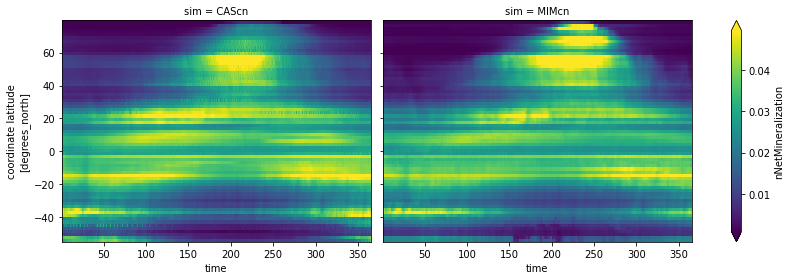

In [108]:
dsDay.isel(time=slice(365,None),sim=CNsim)[var[v]].mean(
    dim='lon').sel(lat=slice(-55,80)).plot(
    x='time', y="lat", col="sim", robust=True,
    figsize=[12,4],col_wrap=2);

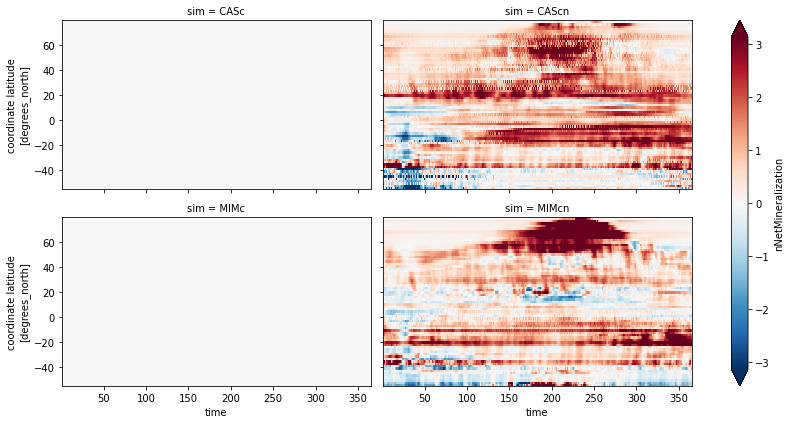

In [110]:
#change in daily fluxes
d_dsDay0 = dsDay.isel(time=slice(0,365)) 
d_dsDay1 = dsDay.isel(time=slice(365,None)) 
d_dsDay1 = d_dsDay1-d_dsDay0
(d_dsDay1[var[v]].mean(dim='lon')*365).sel(lat=slice(-55,80)).plot(
    x='time',y="lat", col="sim", robust=True,
    figsize=[12,6],col_wrap=2);

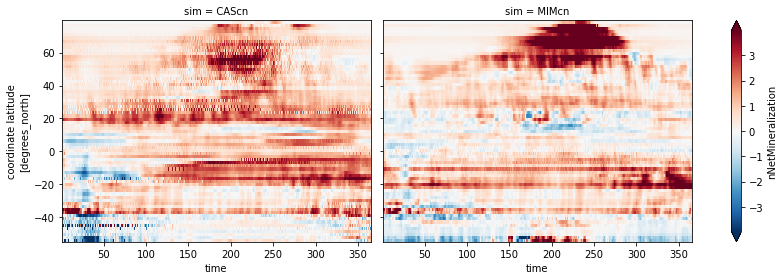

In [109]:
# Differences betweeen models (MIMICS-CASA)
v = 3
(d_dsDay1.isel(sim=CNsim)[var[v]].mean(
    dim='lon')*365).sel(lat=slice(-55,80)).plot(
    x='time',y="lat", col="sim", robust=True,
    figsize=[12,4],col_wrap=2);

In [ ]:
v = 2
(MIMcn.isel(year=1)[var[v]] - MIMcn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2);

In [ ]:
(CAScn.isel(year=1)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2) ;

In [ ]:
# how N limited are arctic systems at end of simulation in each model?
v = 6
simple = (MIMcn[var[v]]- MIMc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

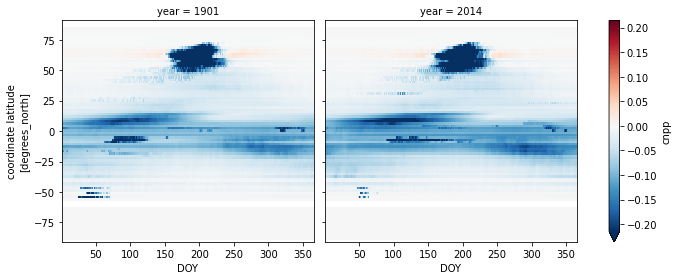

In [46]:
simple = (CAScn[var[v]]- CASc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

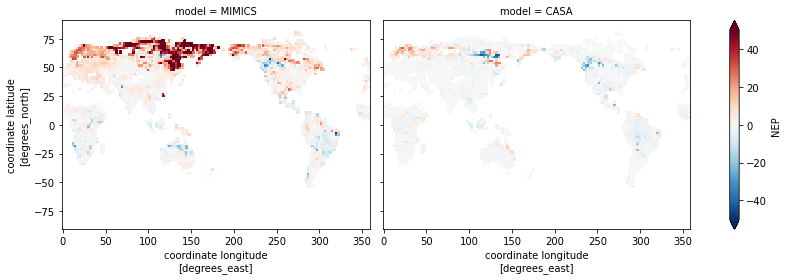

In [47]:
var = 'NEP'
Neff_mim = MIMcnANN[var]-MIMcANN[var]
Neff_cas = CAScnANN[var]-CAScANN[var]
Neff_mim = Neff_mim.isel(time=slice(-20,None)).mean(dim='time') - Neff_mim.isel(time=slice(0,20)).mean(dim='time')
Neff_cas = Neff_cas.isel(time=slice(-20,None)).mean(dim='time') - Neff_cas.isel(time=slice(0,20)).mean(dim='time')
model = xr.DataArray(['MIMICS','CASA'], dims='model', name='model') # or can use np.arange
t = xr.concat([Neff_mim,Neff_cas],dim=model)
t = t*365 #convert from gC/m2/d to gC/m2/y
#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t.plot(x='lon', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);


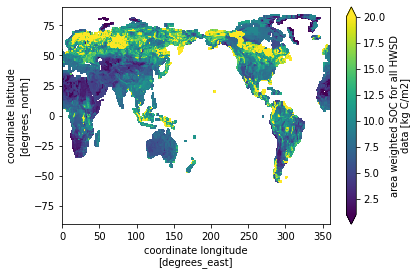

In [49]:
dsOBS['HWSD_SOCall'].plot(vmax=20,vmin=1);

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (6,7,8,9,10,11,12,15,18,22,25,27,28,30,31,32,33,34,35,36,45,51,52,57,58,59,63,64,67,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,86,87,88,89,90,104,115,133,134,135,144,146,147,152) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


google_dir             data_file curator_PersonName  \
0          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
1          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
2          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
3          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
4          AND_10YR_CN  AND_DIRT_10YR_CN_raw      Derek Pierson   
...                ...                   ...                ...   
293587  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293588  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293589  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293590  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   
293591  Wisconsin DIRT   Wisconsin DIRT soil      Derek Pierson   

           curator_organization             curator_email modification_date  \
0       Oregon State University  piersond@oregonstate.edu        2018-03-07   
1       Oregon State University  piersond@oregonstate.edu        2018-03-07   
2       Oregon State University  piersond@oregonstate.edu        2018-03-07   
3       Oregon State University  piersond@oregonstate.edu        2018-03-07   
4       Oregon State University  piersond@oregonstate.edu        2018-03-07   
...                         ...                       ...               ...   
293587  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293588  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293589  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293590  Oregon State University  piersond@oregonstate.edu        2019-09-22   
293591  Oregon State University  piersond@oregonstate.edu        2019-09-22   

                author_PersonName                     author_email  \
0                   Derek Pierson         piersond@oregonstate.edu   
1                   Derek Pierson         piersond@oregonstate.edu   
2                   Derek Pierson         piersond@oregonstate.edu   
3                   Derek Pierson         piersond@oregonstate.edu   
4                   Derek Pierson         piersond@oregonstate.edu   
...                           ...                              ...   
293587  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293588  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293589  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293590  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   
293591  Kate Lajtha, Kim Townsend  lajthak@science.oregonstate.edu   

            author_orcid_id addit_contact_person  ... frc_oc frc_n_tot  \
0       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
1       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
2       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
3       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
4       0000-0003-3413-1693          Kate Lajtha  ...    NaN       NaN   
...                     ...                  ...  ...    ...       ...   
293587                  NaN       Christy Lowney  ...    NaN       NaN   
293588                  NaN       Christy Lowney  ...    NaN       NaN   
293589                  NaN       Christy Lowney  ...    NaN       NaN   
293590                  NaN       Christy Lowney  ...    NaN       NaN   
293591                  NaN       Christy Lowney  ...    NaN       NaN   

       frc_c_to_n bd_methods_notes layer_thick_calc lyr_soc_stock_calc  \
0             NaN              NaN             10.0            3315.26   
1             NaN              NaN             10.0            5399.70   
2             NaN              NaN             10.0            2964.30   
3             NaN              NaN             10.0            4702.70   
4             NaN              NaN             10.0            6266.44   
...           ...              ...              ...                ...   
293587    